In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai import datasets

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/home/quantran/.fastai/data/imagenette-160')

In [4]:
path.ls()

[PosixPath('/home/quantran/.fastai/data/imagenette-160/train'),
 PosixPath('/home/quantran/.fastai/data/imagenette-160/val')]

# Transformation

In [5]:
import random

class Transform(): _order=0
            
class PilTransform(Transform): _order=11

class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x

class PilRandomDihedral(PilTransform):
    def __init__(self, p=0.75): self.p=p*7/8 #Little hack to get the 1/8 identity dihedral transform taken into account.
    def __call__(self, x):
        if random.random()>self.p: return x
        return x.transpose(random.randint(0,6))

from random import randint

def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz)==2 else [sz[0],sz[0]])

def default_crop_size(w,h): return [w,w] if w < h else [h,h]

class GeneralCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR):
        self.resample,self.size = resample,process_sz(size)
        self.crop_size = None if crop_size is None else process_sz(crop_size)

    def default_crop_size(self, w,h): return default_crop_size(w,h)

    def __call__(self, x):
        csize = self.default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *csize), resample=self.resample)

    def get_corners(self, w, h): return (0,0,w,h)

class CenterCrop(GeneralCrop):
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale

    def default_crop_size(self, w,h): return [w/self.scale,h/self.scale]

    def get_corners(self, w, h, wc, hc):
        return ((w-wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

class RandomResizedCrop(GeneralCrop):
    def __init__(self, size, scale=(0.08,1.0), ratio=(3./4., 4./3.), resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale,self.ratio = scale,ratio

    def get_corners(self, w, h, wc, hc):
        area = w*h
        #Tries 10 times to get a proper crop inside the image.
        for attempt in range(10):
            area = random.uniform(*self.scale) * area
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            new_w = int(round(math.sqrt(area * ratio)))
            new_h = int(round(math.sqrt(area / ratio)))
            if new_w <= w and new_h <= h:
                left = random.randint(0, w - new_w)
                top  = random.randint(0, h - new_h)
                return (left, top, left + new_w, top + new_h)

        # Fallback to central crop
        left,top = randint(0,w-self.crop_size[0]),randint(0,h-self.crop_size[1])
        return (left, top, left+self.crop_size[0], top+self.crop_size[1])
        # Fallback to central crop

from torch import FloatTensor,LongTensor

def find_coeffs(orig_pts, targ_pts):
    matrix = []
    #The equations we'll need to solve.
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8, 1)
    #The 8 scalars we seek are solution of AX = B
    return list(torch.solve(B,A)[0][:,0])

def warp(img, size, src_coords, resample=PIL.Image.BILINEAR):
    w,h = size
    targ_coords = ((0,0),(0,h),(w,h),(w,0))
    c = find_coeffs(src_coords,targ_coords)
    res = img.transform(size, PIL.Image.PERSPECTIVE, list(c), resample=resample)
    return res

def uniform(a,b): return a + (b-a) * random.random()

class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.BILINEAR):
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = None if crop_size is None else process_sz(crop_size)

    def __call__(self, x):
        csize = default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        left,top = randint(0,x.size[0]-csize[0]),randint(0,x.size[1]-csize[1])
        top_magn = min(self.magnitude, left/csize[0], (x.size[0]-left)/csize[0]-1)
        lr_magn  = min(self.magnitude, top /csize[1], (x.size[1]-top) /csize[1]-1)
        up_t,lr_t = uniform(-top_magn, top_magn),uniform(-lr_magn, lr_magn)
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left,top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)
    
    
import numpy as np

def make_rgb(item): return item.convert('RGB')
make_rgb._order=0

def np_to_float(x): return torch.from_numpy(np.array(x, dtype=np.float32, copy=False)).permute(2,0,1).contiguous()/255.
np_to_float._order = 30

In [6]:
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]



_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m, std=_s)
norm_imagenette._order = 999

In [190]:
def denorm_chan(x,mean,std):
    return x*std[...,None,None] + mean[...,None,None]
denorm_imagenette = partial(denorm_chan, mean=_m.cuda(), std=_s.cuda())

# Building dataset

In [7]:
def compose2(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

In [8]:
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        try: return self.items[idx]
        except TypeError:
            if isinstance(idx[0],bool):
                assert len(idx)==len(self) # bool mask
                return [o for m,o in zip(idx,self.items) if m]
            return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [9]:
class AEDataset(ListContainer):
    def __init__(self, items, tfms=[], labelers=[]):
        '''
        items: list of PosixPath
        '''
        super().__init__(items)
        self.tfms, self.labeler = tfms, labelers

    def _get(self,fn):
        return compose2(PIL.Image.open(fn),self.tfms)
    def __getitem__(self, idx):
        items = super().__getitem__(idx)
        res = [self._get(o) for o in items] if isinstance(items,Iterable) else self._get(items)
        
        return res,res

In [10]:
def create_databunch(train_ds, valid_ds, bs, **kwargs):
    return DataBunch(
            DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs)
    )

In [11]:
il = (ImageList.from_folder(path)
     .split_by_folder(valid='val'))

In [12]:
il.train.items

array([PosixPath('/home/quantran/.fastai/data/imagenette-160/train/n03000684/n03000684_22294.JPEG'),
       PosixPath('/home/quantran/.fastai/data/imagenette-160/train/n03000684/n03000684_16537.JPEG'),
       PosixPath('/home/quantran/.fastai/data/imagenette-160/train/n03000684/n03000684_18140.JPEG'),
       PosixPath('/home/quantran/.fastai/data/imagenette-160/train/n03000684/n03000684_13440.JPEG'), ...,
       PosixPath('/home/quantran/.fastai/data/imagenette-160/train/n03394916/n03394916_29580.JPEG'),
       PosixPath('/home/quantran/.fastai/data/imagenette-160/train/n03394916/n03394916_60793.JPEG'),
       PosixPath('/home/quantran/.fastai/data/imagenette-160/train/n03394916/n03394916_16322.JPEG'),
       PosixPath('/home/quantran/.fastai/data/imagenette-160/train/n03394916/n03394916_24164.JPEG')], dtype=object)

In [13]:
size = 128
# tfms = [make_rgb, RandomResizedCrop(size, scale=(0.5,1)), PilRandomFlip(),np_to_float,norm_imagenette]
tfms = [make_rgb, CenterCrop(size),PilRandomFlip(),np_to_float,norm_imagenette]

val_tfms = [make_rgb, CenterCrop(size), np_to_float,norm_imagenette]

In [14]:
[t._order for t in tfms]

[0, 11, 11, 30, 999]

In [15]:
train_ds = AEDataset(il.train.items,tfms)
val_ds = AEDataset(il.valid.items,val_tfms)

In [16]:
bs=64
db = create_databunch(train_ds,val_ds,bs)

In [48]:
# %timeit -n 10 _ = next(iter(db.train_dl))

91.4 ms ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
def get_databunch(tfms=None,bs=64,size=128):
    il = (ImageList.from_folder(path)
     .split_by_folder(valid='val'))
    
    if tfms is None: tfms = [make_rgb, CenterCrop(size),PilRandomFlip(),np_to_float,norm_imagenette]
    val_tfms = [make_rgb, CenterCrop(size), np_to_float,norm_imagenette]
    
    train_ds = AEDataset(il.train.items,tfms)
    val_ds = AEDataset(il.valid.items,val_tfms)
    return create_databunch(train_ds,val_ds,bs)

# Model

In [ ]:
def flatten(x): return x.view(x.shape[0],-1)

In [18]:
def build_enc_dec(hls,is_enc = True):
    def linear_relu(i,o):
        return nn.Sequential(nn.Linear(i,o),nn.ReLU(True))
    
    l = len(hls)
    if is_enc:
        return nn.Sequential(*[linear_relu(hls[i],hls[i+1]) for i in range(l-1)])
    return nn.Sequential( *([linear_relu(hls[i],hls[i-1]) for i in range(l-1,0,-1)] + [nn.Tanh()]) )


In [20]:
class SimpleEncoderModel(nn.Module):
    def __init__(self,hidden_layers):
        super().__init__()
        self.encoder = build_enc_dec(hidden_layers,True)
        self.decoder = build_enc_dec(hidden_layers,False)

    def forward(self, x):
        x = flatten(x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
# class ConvEncoderModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
#             nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
#             nn.ReLU(True),
#             nn.ConvTranspose2d(8, 3, 2, stride=2, padding=1),  # b, 1, 28, 28
#             nn.Tanh()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [22]:
# from fastai.callbacks.hooks import *
# def model_summary(model,xb,print_mod=False):
#     mods= model.children()
#     f = lambda mod,inp,out: print(f"====\n{mod}\n" if print_mod else "", out.shape)
#     with Hooks(mods, f) as hooks: model(xb)

In [23]:
# x,y = next(iter(db.train_dl))
# model_summary(ac_model,x,False)

In [24]:
layers = [128*128*3,256,128,16,3]
ac_model = SimpleEncoderModel(layers).cuda()

In [25]:
def mse_flat(preds,targs,**kwargs):
    return MSELossFlat()(preds,flatten(targs))


In [26]:
# tfms = [make_rgb, RandomResizedCrop(size, scale=(0.35,1)), np_to_float, PilRandomFlip(),norm_imagenette]

In [27]:
db = get_databunch()

In [28]:
learn = Learner(db,SimpleEncoderModel(layers).cuda(),loss_func = mse_flat,metrics=[])

In [29]:
hook_layers = list(list(learn.model.children())[0]) + list(list(learn.model.children())[1][:-1])

In [30]:
hook_layers

[Sequential(
   (0): Linear(in_features=49152, out_features=256, bias=True)
   (1): ReLU(inplace)
 ), Sequential(
   (0): Linear(in_features=256, out_features=128, bias=True)
   (1): ReLU(inplace)
 ), Sequential(
   (0): Linear(in_features=128, out_features=16, bias=True)
   (1): ReLU(inplace)
 ), Sequential(
   (0): Linear(in_features=16, out_features=3, bias=True)
   (1): ReLU(inplace)
 ), Sequential(
   (0): Linear(in_features=3, out_features=16, bias=True)
   (1): ReLU(inplace)
 ), Sequential(
   (0): Linear(in_features=16, out_features=128, bias=True)
   (1): ReLU(inplace)
 ), Sequential(
   (0): Linear(in_features=128, out_features=256, bias=True)
   (1): ReLU(inplace)
 ), Sequential(
   (0): Linear(in_features=256, out_features=49152, bias=True)
   (1): ReLU(inplace)
 )]

# Init

In [31]:
for l in hook_layers:
    if isinstance(l, nn.Sequential):
        nn.init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

# Layer hooks visualization

In [37]:
from collections import defaultdict
from fastai.callbacks.hooks import *

In [33]:
hooks_means = defaultdict(list)
hooks_stds = defaultdict(list)
hooks_hists = defaultdict(list)

In [34]:
# means,stds,hists = [],[],[]
def append_stats(mod, inp, outp):
    if mod.training:
        hooks_means[str(mod)].append(outp.data.mean().cpu())
        hooks_stds[str(mod)].append(outp.data.std().cpu())
        hooks_hists[str(mod)].append(outp.data.cpu().histc(40,-7,7))

In [35]:
len(hook_layers)

8

In [38]:
with Hooks(hook_layers,append_stats) as hooks:
    learn.fit_one_cycle(1, 2e-3)

epoch,train_loss,valid_loss,time
0,0.865624,0.858868,00:22


In [39]:
len(hooks_means)

8

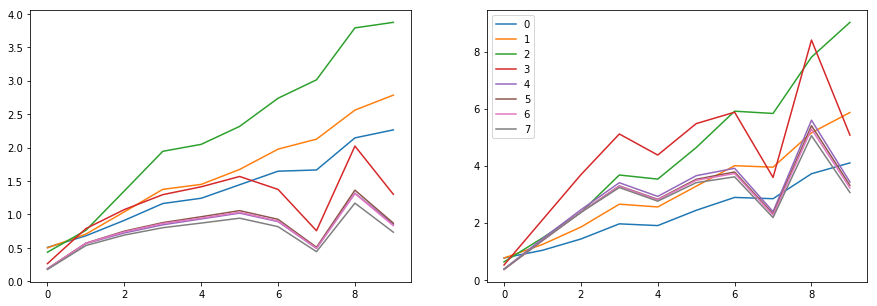

In [41]:
#plot mean vs std for first few ite
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
for m in hook_layers:
    ms,ss = hooks_means[str(m)],hooks_stds[str(m)]
    ax0.plot(ms[:10])
    ax1.plot(ss[:10])
plt.legend(range(len(hook_layers)));

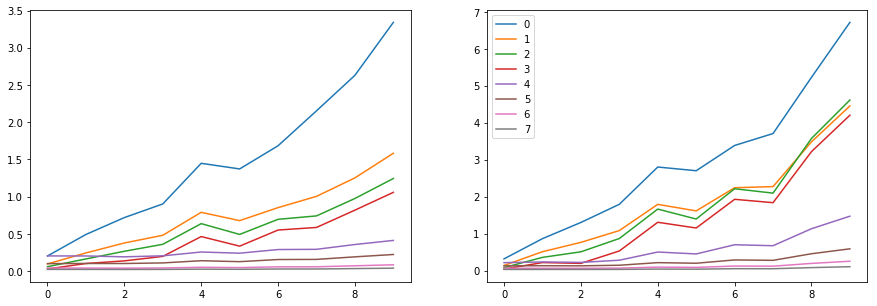

In [96]:
# #plot mean vs std for first few ite
# fig,(ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
# for m in hook_layers:
#     ms,ss = hooks_means[str(m)],hooks_stds[str(m)]
#     ax0.plot(ms[:10])
#     ax1.plot(ss[:10])
# plt.legend(range(len(hook_layers)));

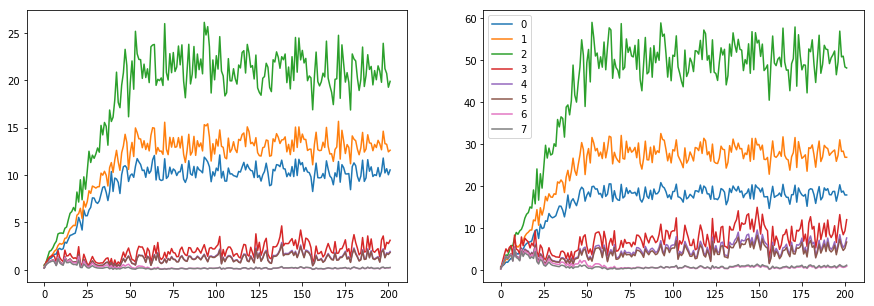

In [42]:
#full mean and std
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
for m in hook_layers:
    ms,ss = hooks_means[str(m)],hooks_stds[str(m)]
    ax0.plot(ms)
    ax1.plot(ss)
plt.legend(range(len(hook_layers)));

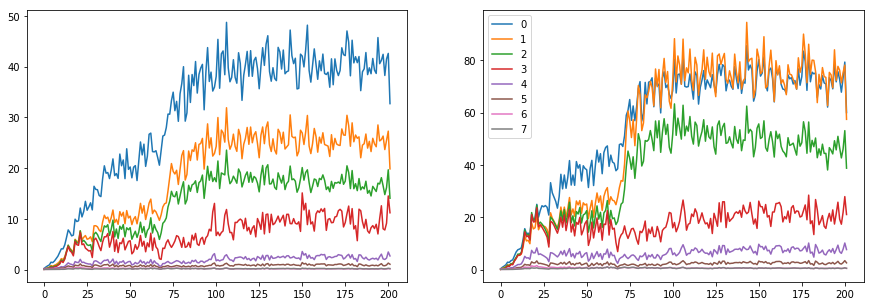

In [97]:
# #full mean and std
# fig,(ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
# for m in hook_layers:
#     ms,ss = hooks_means[str(m)],hooks_stds[str(m)]
#     ax0.plot(ms)
#     ax1.plot(ss)
# plt.legend(range(len(hook_layers)));

In [43]:
def get_hist(h): return torch.stack(h).t().float().log1p() # Return matrix (# bins, # iterations)

<BarContainer object of 40 artists>

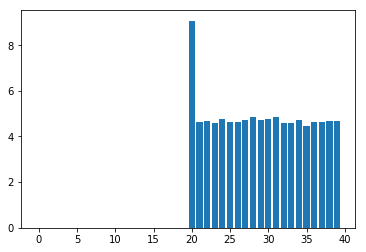

In [44]:
plt.bar(torch.arange(40),get_hist(hooks_hists[str(hook_layers[0])])[:,50])

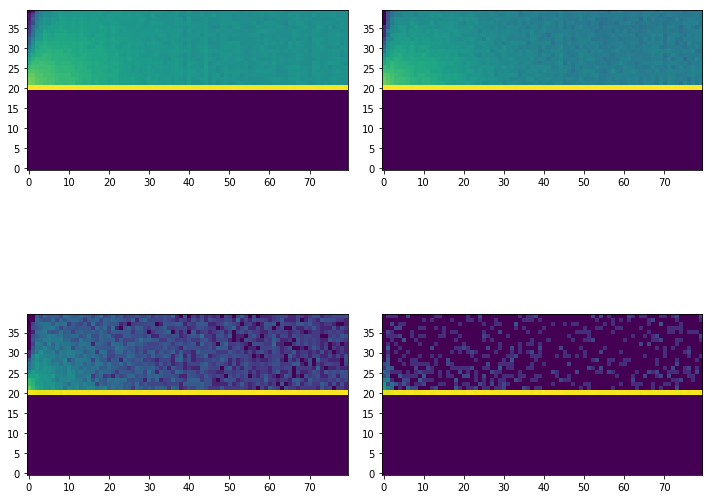

In [45]:
# plot histogram
fig,axes = plt.subplots(2,2, figsize=(10,10))
for ax,m in zip(axes.flatten(), hook_layers[:4]):
    ax.imshow(get_hist(hooks_hists[str(m)])[:,:80], origin='lower')
    ax.axis('on')
plt.tight_layout()

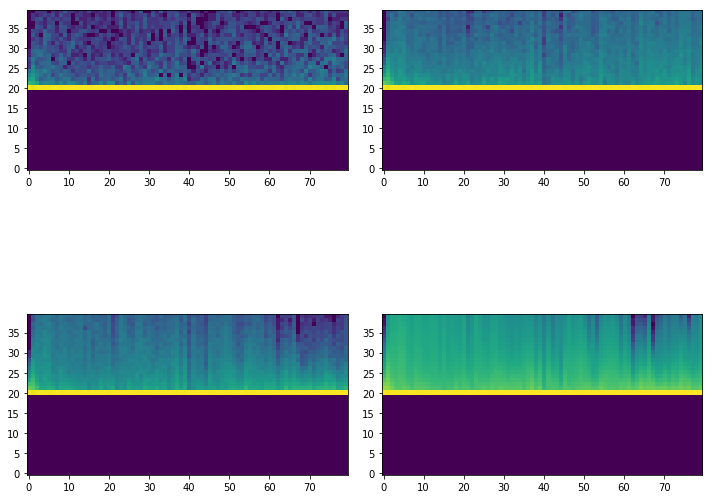

In [46]:
# plot histogram
fig,axes = plt.subplots(2,2, figsize=(10,10))
for ax,m in zip(axes.flatten(), hook_layers[4:]):
    ax.imshow(get_hist(hooks_hists[str(m)])[:,:80], origin='lower')
    ax.axis('on')
plt.tight_layout()

In [47]:
def get_min(h):
    h1 = torch.stack(h).t().float()
    return h1[19:22].sum(0)/h1.sum(0) # bin 19,20 and 21 are the middle, where ~0 values stay

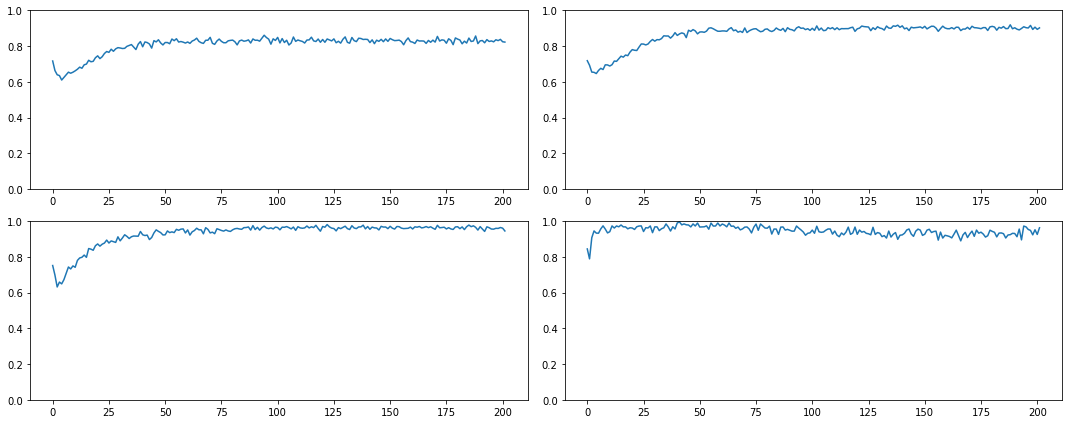

In [48]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,m in zip(axes.flatten(), hook_layers[:4]):
    ax.plot(get_min(hooks_hists[str(m)]))
    ax.set_ylim(0,1)
plt.tight_layout()

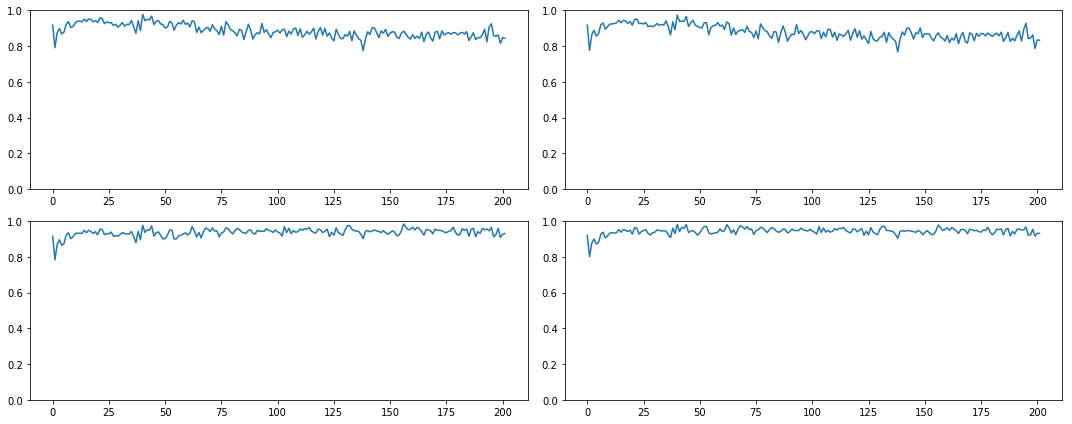

In [49]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,m in zip(axes.flatten(), hook_layers[4:]):
    ax.plot(get_min(hooks_hists[str(m)]))
    ax.set_ylim(0,1)
plt.tight_layout()

# With general RELU + init

In [81]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None): # we can now add leaky portion/ subtraction/ max RELU value to clip
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [82]:
def build_enc_dec(hls,is_enc = True,**kwargs):
    def linear_relu(i,o):
        return nn.Sequential(nn.Linear(i,o),GeneralRelu(**kwargs))
    
    l = len(hls)
    if is_enc:
        return nn.Sequential(*[linear_relu(hls[i],hls[i+1]) for i in range(l-1)])
    return nn.Sequential( *([linear_relu(hls[i],hls[i-1]) for i in range(l-1,0,-1)] + [nn.Tanh()]) )


class SimpleEncoderModel(nn.Module):
    def __init__(self,hidden_layers,**kwargs):
        super().__init__()
        self.encoder = build_enc_dec(hidden_layers,True,**kwargs)
        self.decoder = build_enc_dec(hidden_layers,False,**kwargs)

    def forward(self, x):
        x = flatten(x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [118]:
layers = [128*128*3,256,64,3]

In [124]:
db = get_databunch()

learn = Learner(db,SimpleEncoderModel(layers,leak=0.07,sub=0.4,maxv=5.).cuda(),loss_func = mse_flat,metrics=[])

hook_layers = list(list(learn.model.children())[0]) + list(list(learn.model.children())[1][:-1])

In [125]:
# init
for l in hook_layers:
    if isinstance(l, nn.Sequential):
        nn.init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

## hook visualization

In [126]:
hooks_means = defaultdict(list)
hooks_stds = defaultdict(list)
hooks_hists = defaultdict(list)

In [127]:
with Hooks(hook_layers,append_stats) as hooks:
    learn.fit_one_cycle(1, 2e-3)

epoch,train_loss,valid_loss,time
0,0.670930,0.652047,00:21


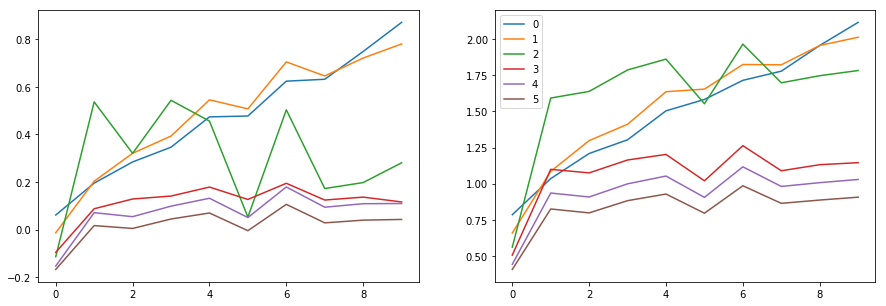

In [128]:
#plot mean vs std for first few ite
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
for m in hook_layers:
    ms,ss = hooks_means[str(m)],hooks_stds[str(m)]
    ax0.plot(ms[:10])
    ax1.plot(ss[:10])
plt.legend(range(len(hook_layers)));

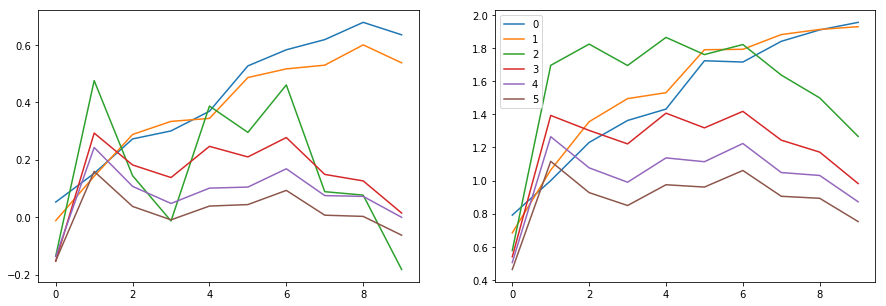

In [105]:
#plot mean vs std for first few ite
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
for m in hook_layers:
    ms,ss = hooks_means[str(m)],hooks_stds[str(m)]
    ax0.plot(ms[:10])
    ax1.plot(ss[:10])
plt.legend(range(len(hook_layers)));

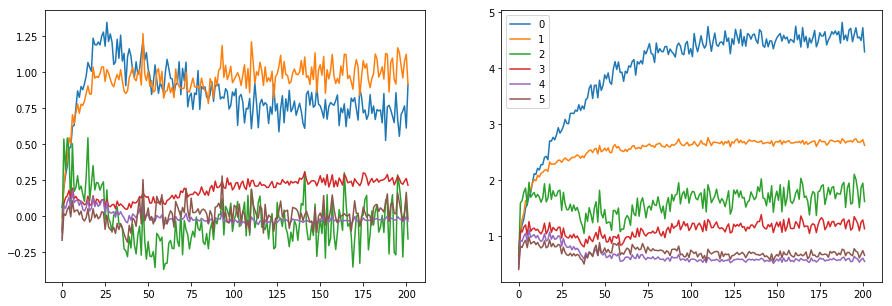

In [129]:
#full mean and std
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
for m in hook_layers:
    ms,ss = hooks_means[str(m)],hooks_stds[str(m)]
    ax0.plot(ms)
    ax1.plot(ss)
plt.legend(range(len(hook_layers)));


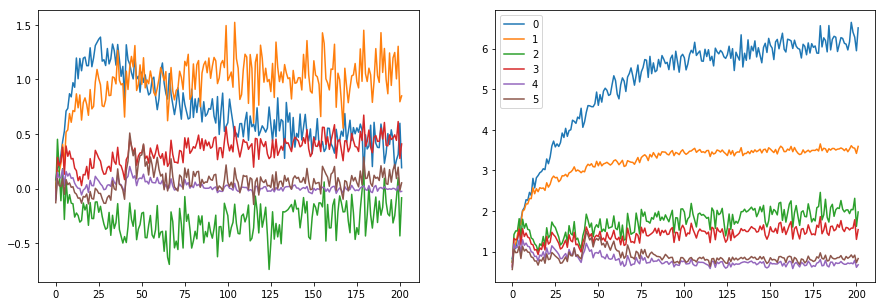

In [91]:
#full mean and std
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
for m in hook_layers:
    ms,ss = hooks_means[str(m)],hooks_stds[str(m)]
    ax0.plot(ms)
    ax1.plot(ss)
plt.legend(range(len(hook_layers)));


<BarContainer object of 40 artists>

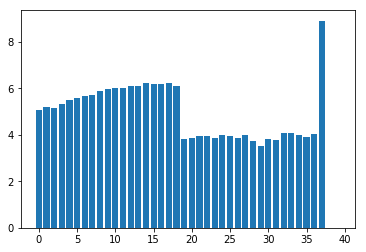

In [92]:
plt.bar(torch.arange(40),get_hist(hooks_hists[str(hook_layers[0])])[:,100])

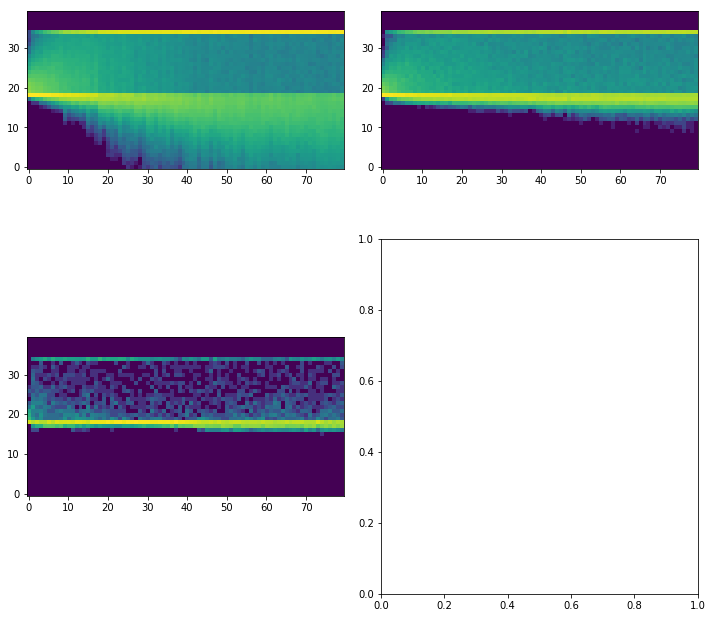

In [130]:
# plot histogram
fig,axes = plt.subplots(2,2, figsize=(10,10))
for ax,m in zip(axes.flatten(), hook_layers[:3]):
    ax.imshow(get_hist(hooks_hists[str(m)])[:,:80], origin='lower')
    ax.axis('on')
plt.tight_layout()

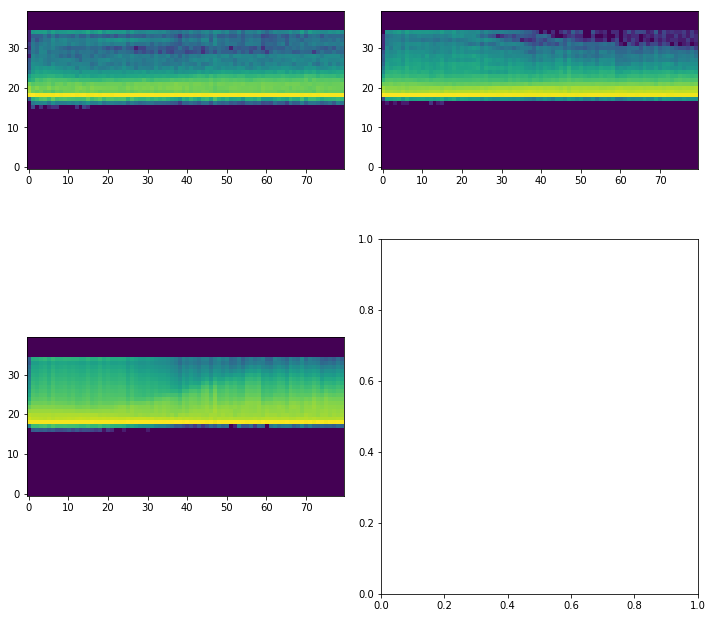

In [131]:
# plot histogram
fig,axes = plt.subplots(2,2, figsize=(10,10))
for ax,m in zip(axes.flatten(), hook_layers[3:]):
    ax.imshow(get_hist(hooks_hists[str(m)])[:,:80], origin='lower')
    ax.axis('on')
plt.tight_layout()

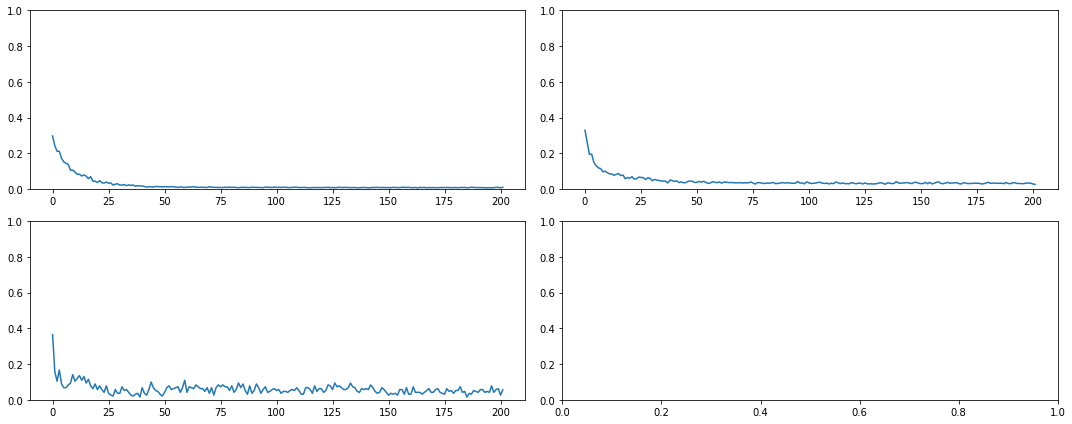

In [132]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,m in zip(axes.flatten(), hook_layers[:3]):
    ax.plot(get_min(hooks_hists[str(m)]))
    ax.set_ylim(0,1)
plt.tight_layout()

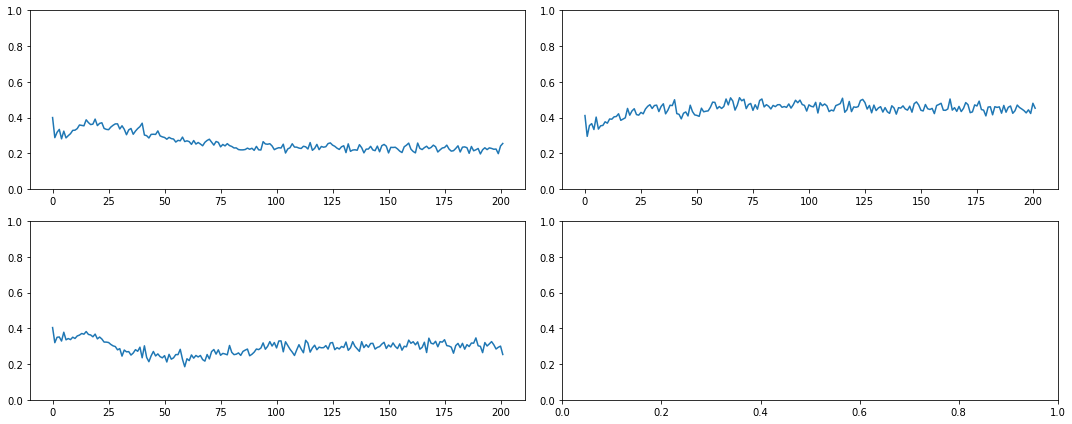

In [100]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,m in zip(axes.flatten(), hook_layers[3:]):
    ax.plot(get_min(hooks_hists[str(m)]))
    ax.set_ylim(0,1)
plt.tight_layout()

# Full training

In [134]:
layers = [128*128*3,256,64,3]

db = get_databunch()

learn = Learner(db,SimpleEncoderModel(layers,leak=0.07,sub=0.4,maxv=5.).cuda(),loss_func = mse_flat,metrics=[])

hook_layers = list(list(learn.model.children())[0]) + list(list(learn.model.children())[1][:-1])

# init
for l in hook_layers:
    if isinstance(l, nn.Sequential):
        nn.init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


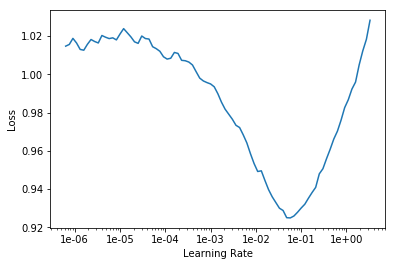

In [135]:
learn.lr_find()
learn.recorder.plot()

In [136]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,time
0,0.698518,0.664300,00:18
1,0.636716,0.618653,00:19
2,0.611951,0.597320,00:19
3,0.604270,0.588852,00:18
4,0.605917,0.594648,00:19
5,0.596351,0.583059,00:19
6,0.589640,0.585684,00:18
7,0.584251,0.582117,00:19
8,0.582539,0.568700,00:19
9,0.578175,0.565451,00:18


In [139]:
# learn.save('simple_enc_resize_crop')

In [140]:
learn.load('simple_enc_resize_crop');

# Look at prediction

In [169]:
learn.load('simple_enc_resize_crop');

/home/quantran/anaconda3/envs/python37/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GeneralRelu. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/quantran/anaconda3/envs/python37/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SimpleEncoderModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [170]:
m = learn.model.eval()

In [216]:
x,y = next(iter(db.valid_dl))

In [217]:
y_pred = m(x)

In [218]:
y_pred.shape

torch.Size([128, 49152])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


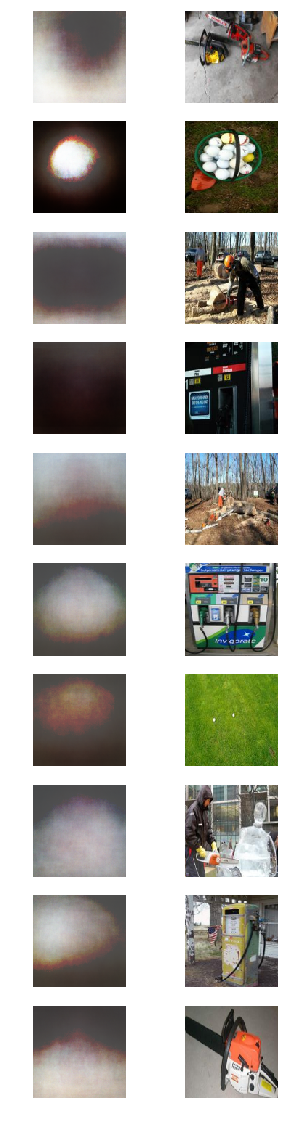

In [219]:
n=10
fig,axes = plt.subplots(n,2, figsize=(5,20))
for i,idx in enumerate(np.random.permutation(y_pred.shape[0])[:n]):
    show_image(((y_pred[idx]+1)/2).view(3,128,128),axes[i][0])
    show_image(denorm_imagenette(y[idx]),axes[i][1])